# Developing Well Calibrated Illness Severity Scores
## Model Analysis
### C.V. Cosgriff, MIT Critical Data

With our models developed, we will examine their discrimination and calibration. Discrimination will be examined via area under the reciever-operator characteristic curve (AUC). Calibration will be examined via reliability curves and observed-to-predicted mortality ratios. Metrics will have conservative 95% confidence intervals constructed via bootstrapping.

__Notebook Outline:__
* Envrionment preparation
* Load held out test set
* Full Cohort Models
* High-risk Cohort Models
* Feature Analysis
    
## 0 - Environement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance

import pickle

# "Tableau 20" colors as RGB for plotting
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - Models, Data, and Helper Functions

We first load up the fully trained models.

In [2]:
ridge_classifier = pickle.load(open('./models/ridge_full-cohort', 'rb'))
ridge_classifier_HR = pickle.load(open('./models/ridge_HR-cohort', 'rb'))
xgb_classifier = pickle.load(open('./models/xgb_full-cohort', 'rb'))
xgb_classifier_HR = pickle.load(open('./models/xgb_HR-cohort', 'rb'))

We then load up the training and testing data.

In [3]:
test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

We'll also need the high-risk testing cohort.

In [4]:
test_X_HR = test_X[(test_apache >= 0.10), :]
test_y_HR = test_y[test_apache >= 0.10]

Finally, we introduce  helper functions for calculating the CI for the metrics via bootstrapping and for generating plots.

In [5]:
def auc_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1 - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_auc = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        auc = roc_auc_score(y_true[indices], f_hat[indices])
        bootstrapped_auc.append(auc)

    sorted_scores = np.array(bootstrapped_auc)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_opr = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        opr = y_true[indices].mean() / f_hat[indices].mean()
        bootstrapped_opr.append(opr)

    sorted_scores = np.array(bootstrapped_opr)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def gen_auc_plot(models, names, colors, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        roc = roc_curve(y, f_hat[:, 1])
        auc = roc_auc_score(y, f_hat[:, 1])
        plt.plot(roc[0], roc[1], color=colors[i], 
         label='{0}\n(AUC = {1:.3f} [{2:.3f}, {3:.3f}])'.format(names[i], auc, *auc_ci(f_hat[:, 1], y)))
    
    plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if save_name != None:
        plt.savefig('./figures/' + save_name + '.svg', bbox_inches='tight')
    plt.show()
    
def gen_calib_plot(models, names, colors, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        fraction_of_positives, mean_predicted_value = calibration_curve(y, f_hat[:, 1], n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, color=colors[i], 
         label=names[i])
    
    plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
    plt.ylabel("Fraction of positives")
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Mean predicted value")
    plt.grid()
    if save_name != None:
        plt.savefig('./figures/' + save_name + '.svg', bbox_inches='tight')
    plt.show()
    
def op_ratio(model, X, y):
    f_hat = model.predict_proba(X)
    observed = y.mean()
    predicted = f_hat[:, 1].mean()
    return (observed / predicted, *op_ratio_ci(f_hat[:, 1], y))

## 2 - Models Fit in the RS Cohort

Here we will examine how the models trained in the full cohort perform in a cohort composed of only high-risk patients.

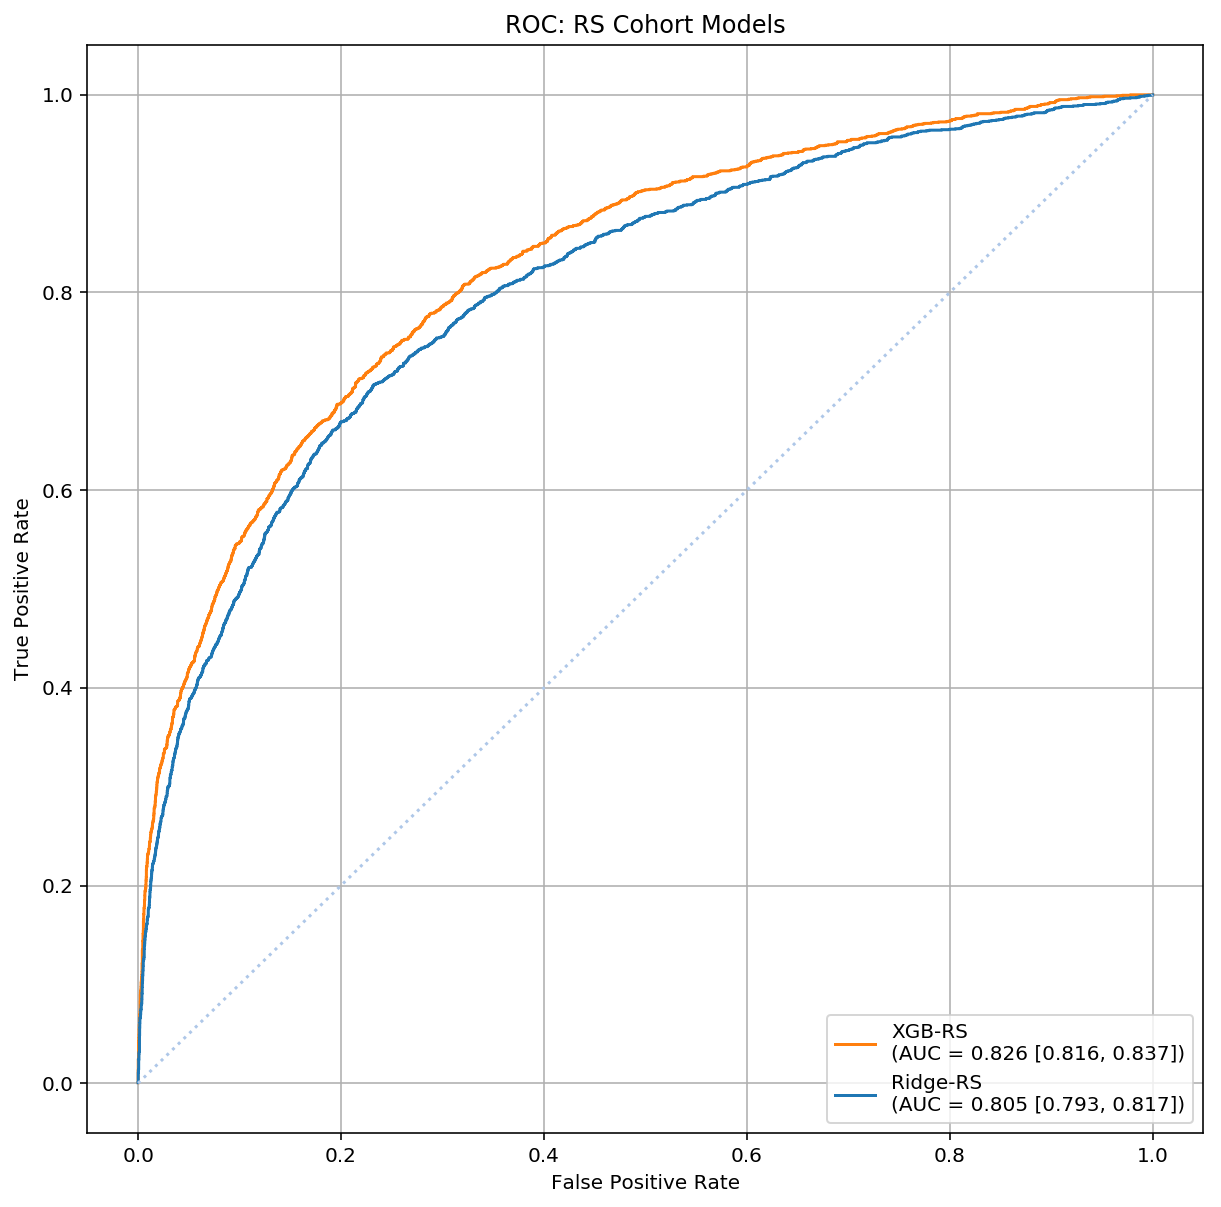

In [6]:
gen_auc_plot(models=[xgb_classifier, ridge_classifier], names=['XGB-RS', 'Ridge-RS'], 
             colors=[tableau20[2], tableau20[0]], title='ROC: RS Cohort Models', X=test_X_HR, 
             y=test_y_HR, save_name='auc_RS')

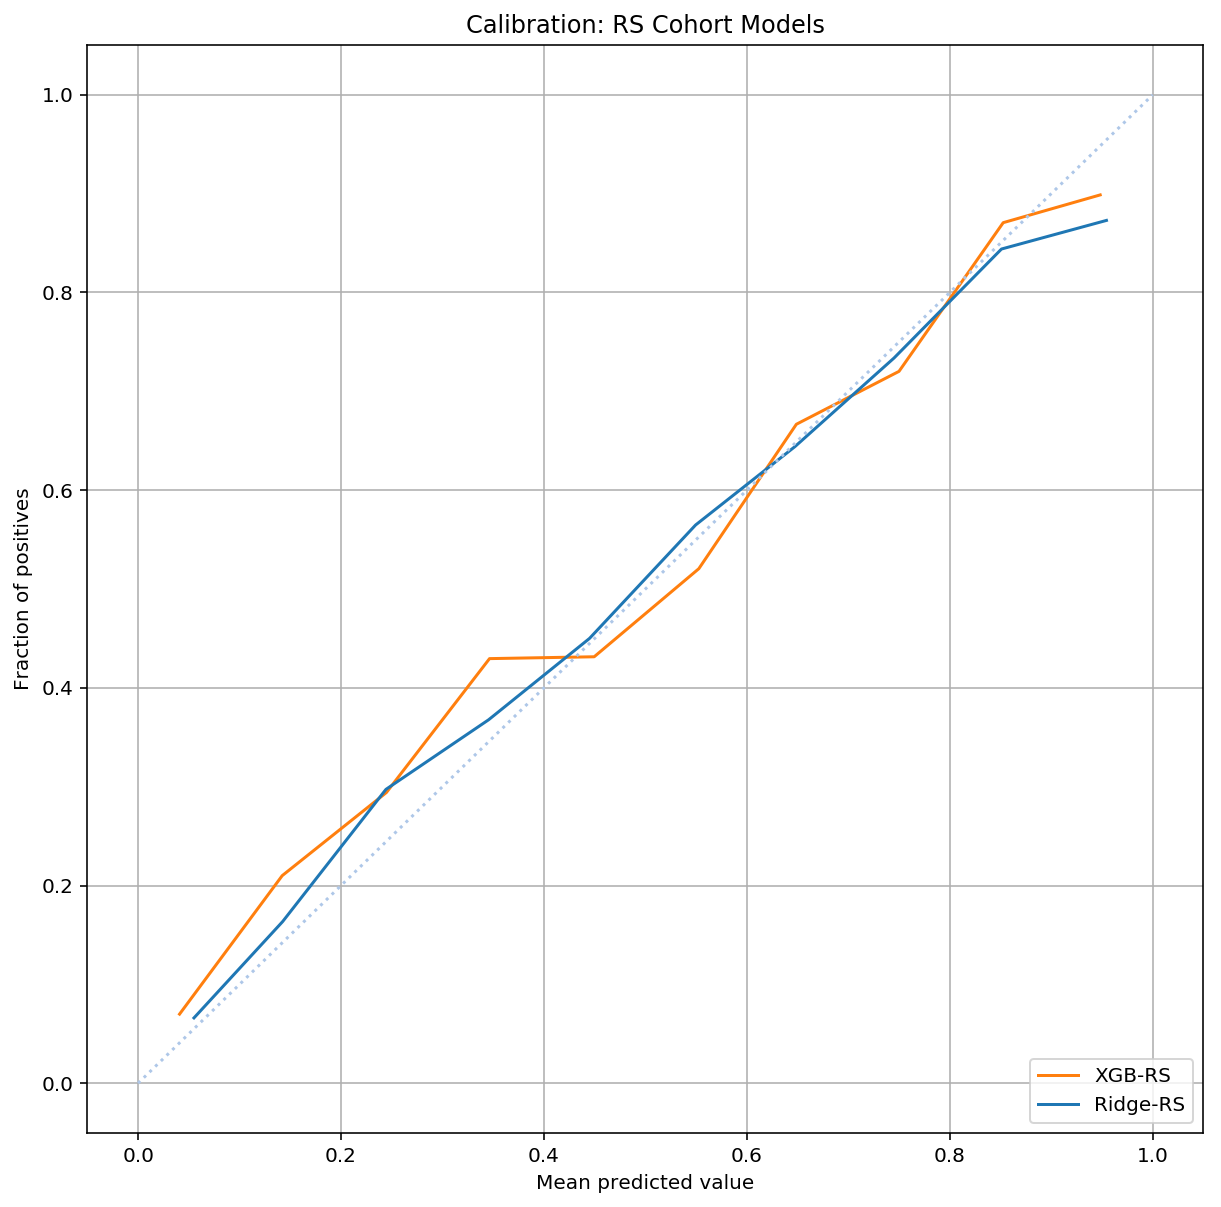

In [7]:
gen_calib_plot(models=[xgb_classifier, ridge_classifier], names=['XGB-RS', 'Ridge-RS'], 
             colors=[tableau20[2], tableau20[0]], title='Calibration: RS Cohort Models', 
               X=test_X_HR, y=test_y_HR, save_name='rel_RS')

In [8]:
print('Ridge-RS OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(ridge_classifier, test_X_HR, test_y_HR)))
print('XGB-RS OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(xgb_classifier, test_X_HR, test_y_HR)))

Ridge-RS OPR: 1.080 [1.043, 1.118]
XGB-RS OPR: 1.180 [1.141, 1.222]


## 4 - Models Fit in the HR Cohort

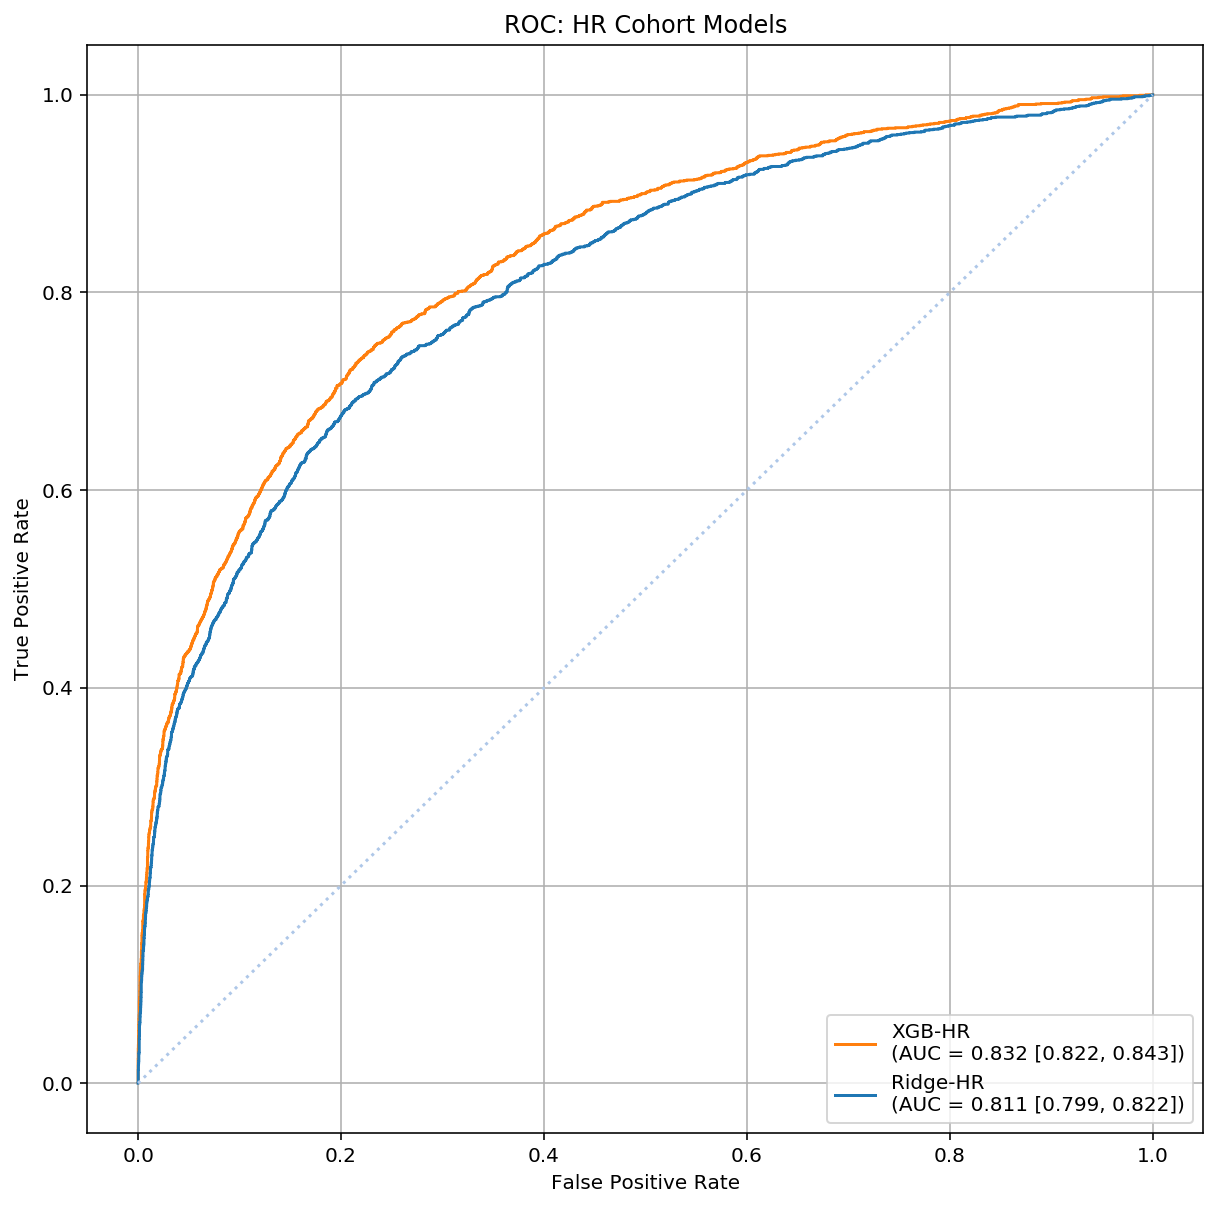

In [9]:
gen_auc_plot(models=[xgb_classifier_HR, ridge_classifier_HR], names=['XGB-HR', 'Ridge-HR'], 
             colors=[tableau20[2], tableau20[0]], title='ROC: HR Cohort Models', X=test_X_HR, 
             y=test_y_HR, save_name='auc_HR')

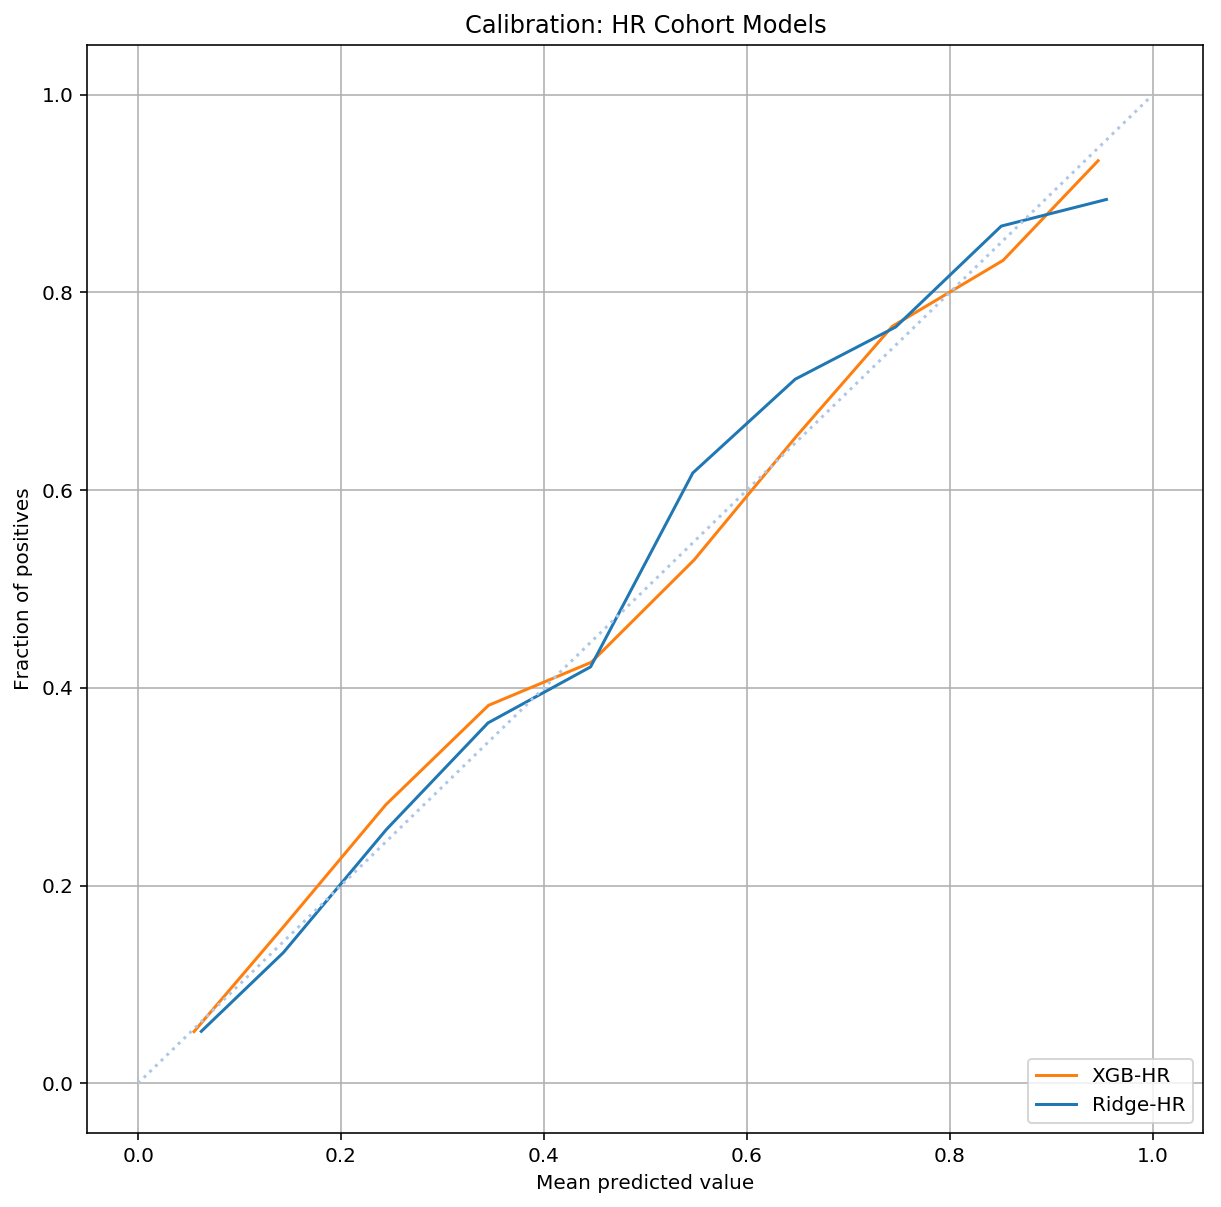

In [10]:
gen_calib_plot(models=[xgb_classifier_HR, ridge_classifier_HR], names=['XGB-HR', 'Ridge-HR'], 
             colors=[tableau20[2], tableau20[0]], title='Calibration: HR Cohort Models', 
               X=test_X_HR, y=test_y_HR, save_name='rel_HR')

In [11]:
print('Ridge-HR OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(ridge_classifier_HR, test_X_HR, test_y_HR)))
print('XGB-HR OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(xgb_classifier_HR, test_X_HR, test_y_HR)))

Ridge-HR OPR: 0.993 [0.959, 1.027]
XGB-HR OPR: 1.033 [0.998, 1.068]


## 5 - Feature Analysis

The features of the ridge models may be examined via the odds ratios associated with each feature. Similary, although not directly comparable, the importance matrix of the gradient boosted models may provide insight. 

We first extract the feature names.

In [12]:
feature_names = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').columns

For the ridge models, we'll manually extract the coefficient array, which has its order preserved, and assign the feature names so that we can easily read the sorted list. We examine the full cohort model first.

,odds_ratio
age,1.350785
albumin_min,0.775587
rr_mean,1.267079
gcs_motor,0.804186
hr_mean,1.235415
spo2_mean,0.817083
adx_CARDARREST,1.213688
lactate_max,1.201799
map_aperiodic_mean,0.834671
adx_ICH,1.190908


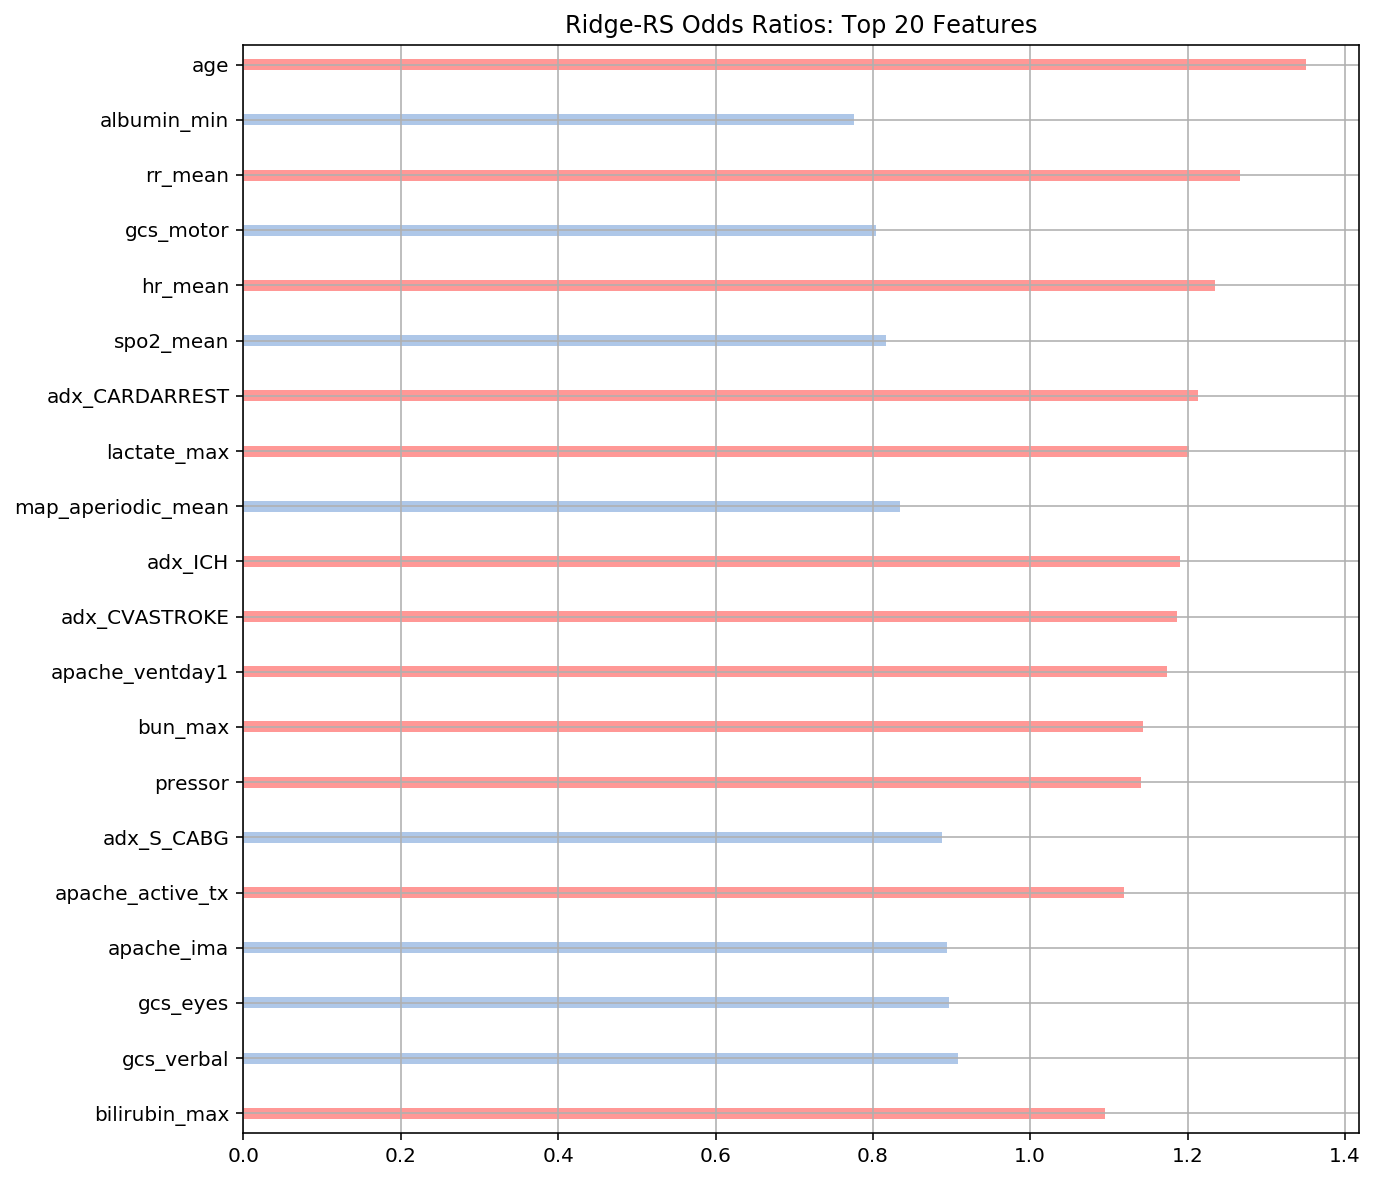

In [13]:
ridge_coef = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier.named_steps['ridge'].coef_.ravel())}
ridge_coef = pd.DataFrame.from_dict(ridge_coef, orient='index', columns=['odds_ratio'])
ridge_rs_coef = ridge_coef.reindex(np.log(ridge_coef.odds_ratio).abs().sort_values(ascending=False).index).iloc[0:20, :]
display(ridge_rs_coef)
# plotting
ridge_rs_coef = ridge_rs_coef.reindex(index=ridge_rs_coef.index[::-1])
pos_neg = np.log(ridge_rs_coef.odds_ratio) > 0
color_map = pos_neg.map({True: tableau20[7], False: tableau20[1]})
plt.figure(figsize=(10, 10))
ridge_rs_coef.plot(kind='barh', grid=True, sort_columns=False,
                   title='Ridge-RS Odds Ratios: Top 20 Features',
                   color=[color_map.values], ax=plt.axes(), width=0.20,
                   legend=False)
plt.savefig('./figures/ridge_RS-feat.svg', bbox_inches='tight')

We carry out the same steps in the HR subcohort model.

,odds_ratio
spo2_mean,0.707503
age,1.296844
gcs_motor,0.775424
albumin_min,0.782059
adx_CARDARREST,1.263530
hr_mean,1.237433
adx_ICH,1.217730
rr_mean,1.216088
lactate_max,1.215102
map_aperiodic_mean,0.823974


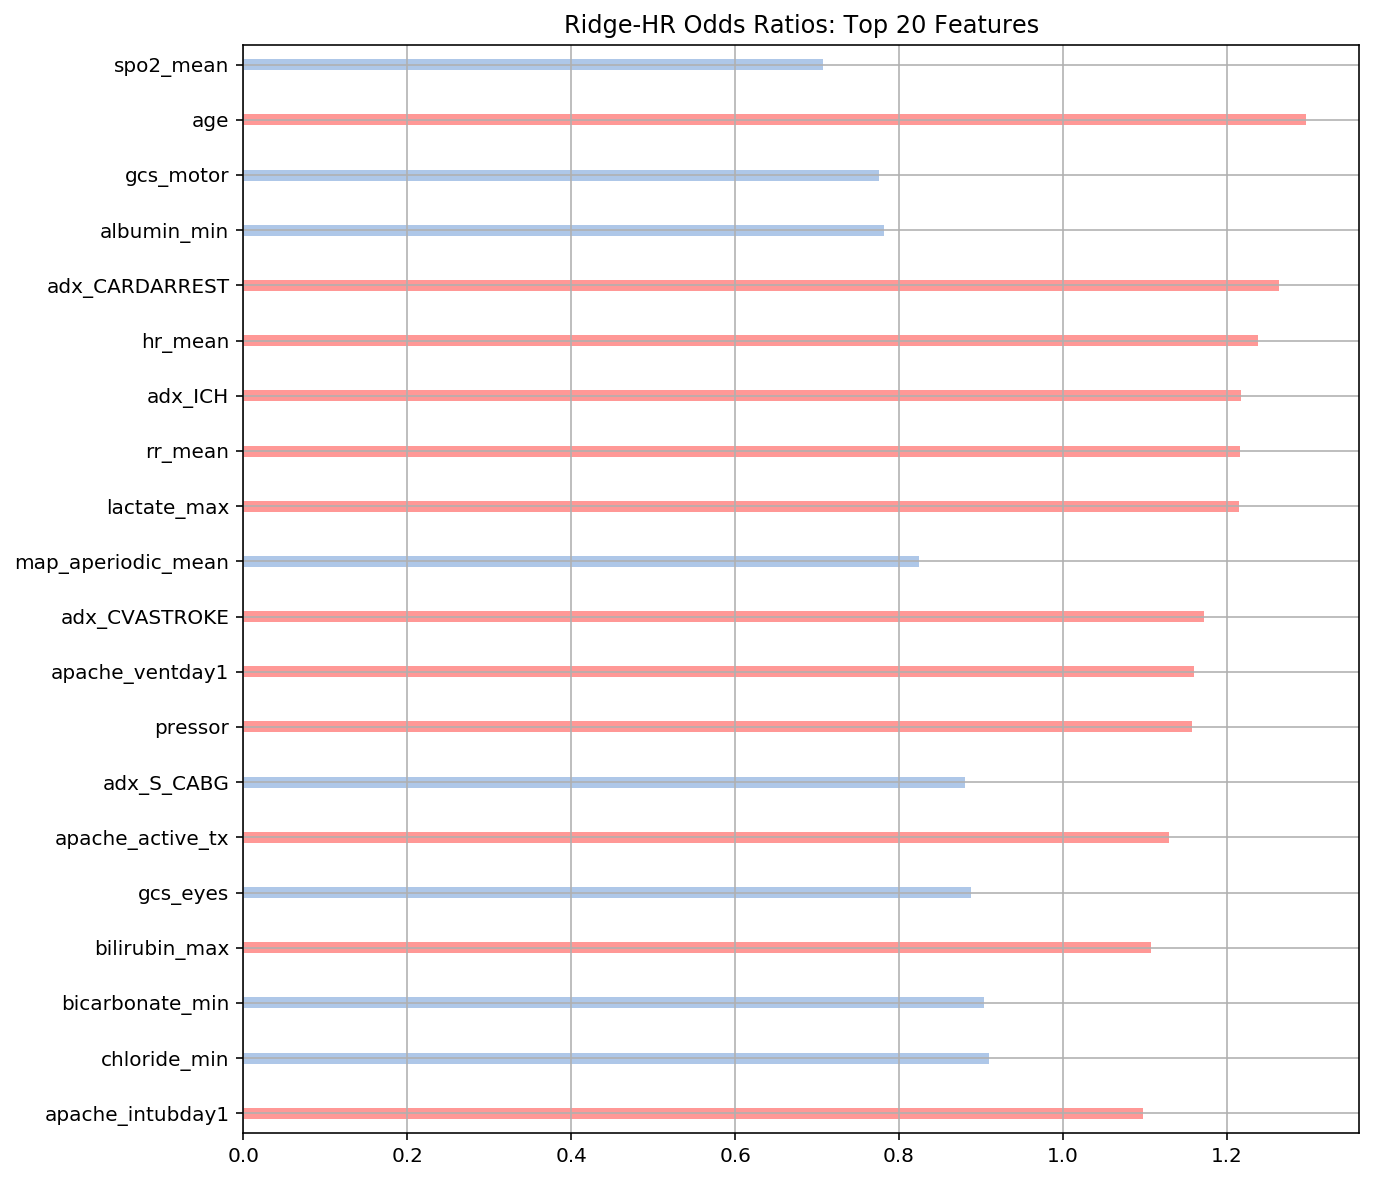

In [14]:
ridge_coef_HR = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier_HR.named_steps['ridge'].coef_.ravel())}
ridge_coef_HR = pd.DataFrame.from_dict(ridge_coef_HR, orient='index', columns=['odds_ratio'])
ridge_HR_coef = ridge_coef_HR.reindex(np.log(ridge_coef_HR.odds_ratio).abs().sort_values(ascending=False).index).iloc[0:20, :]
display(ridge_HR_coef)
# plotting
ridge_HR_coef = ridge_HR_coef.reindex(index=ridge_HR_coef.index[::-1])
pos_neg = np.log(ridge_HR_coef.odds_ratio) > 0
color_map = pos_neg.map({True: tableau20[7], False: tableau20[1]})
plt.figure(figsize=(10, 10))
ridge_HR_coef.plot(kind='barh', grid=True, sort_columns=False, 
                   title='Ridge-HR Odds Ratios: Top 20 Features', 
                   color=[color_map.values], ax=plt.axes(), width=0.20,
                   legend=False)
plt.savefig('./figures/ridge_HR-feat.svg', bbox_inches='tight')

The top 20 features in both by OR magnitude are similar for both the full and subcohort models with notable small differences. For example, in the high-risk cohort a cardiac arrest admission suggests mortality odds that are greater than in the full cohort. 

We next turn to the XGB models. For these we'll need to map the feature names onto the models internal representation of the features and thene xtract the importance matrices. Again we start with the full cohort models. XGB also provides a nice function for visualizing the matrix.

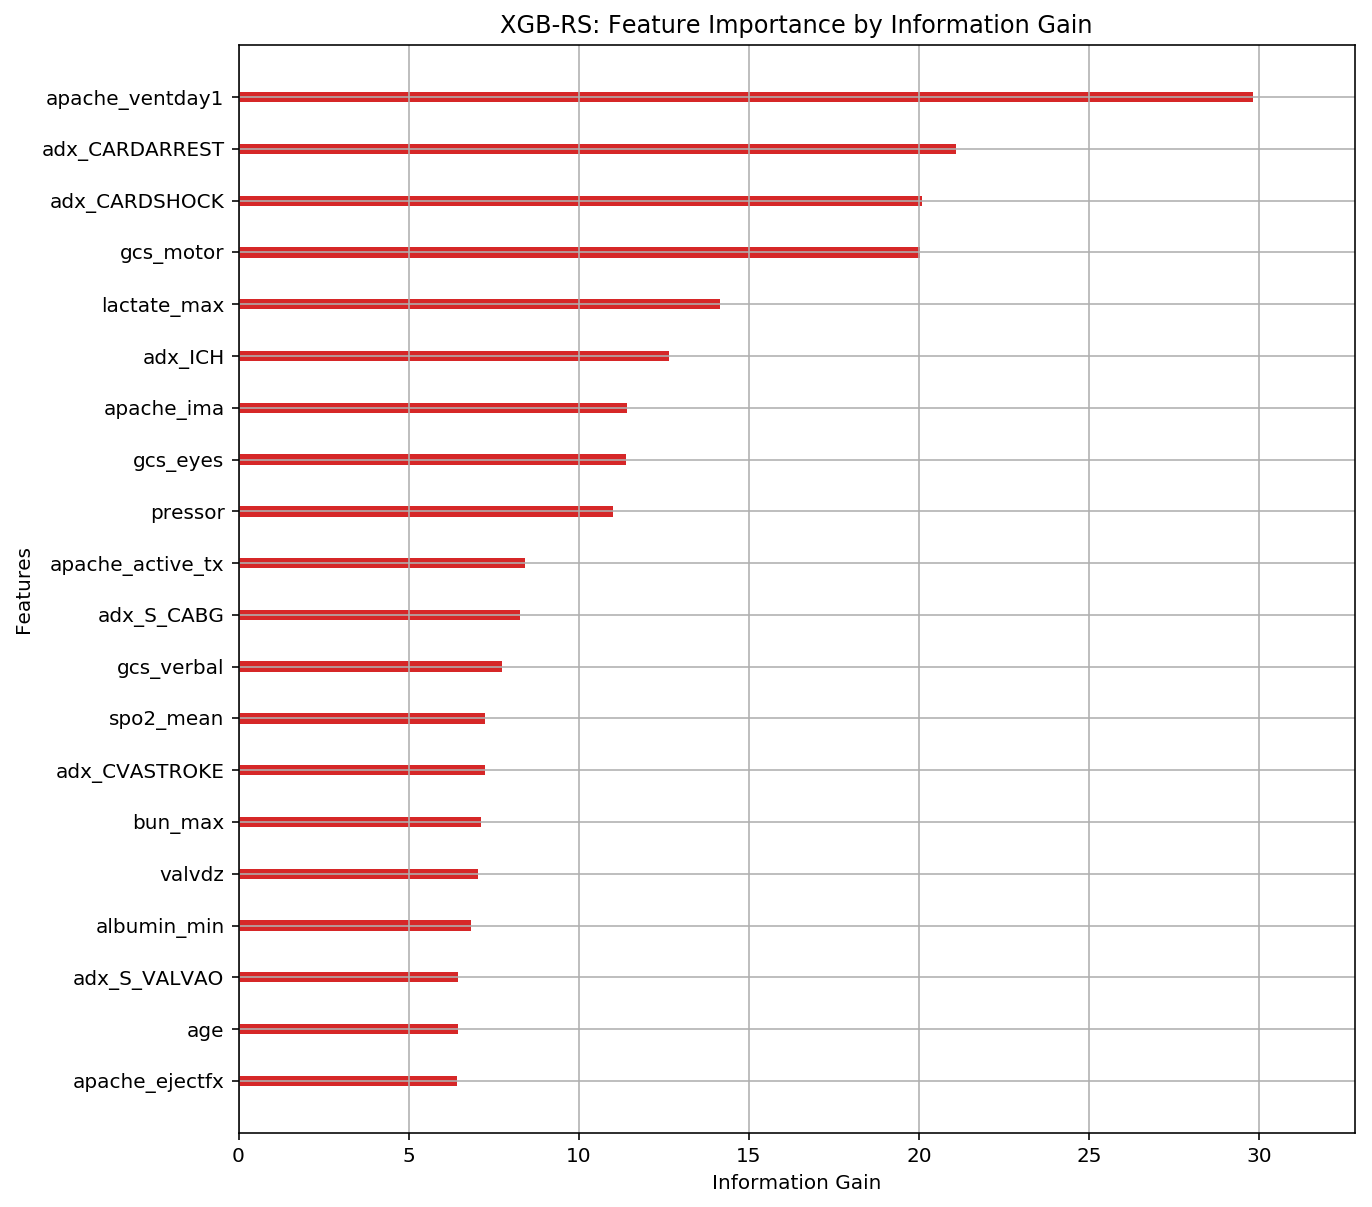

<Figure size 432x288 with 0 Axes>

In [15]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
               title='XGB-RS: Feature Importance by Information Gain')
plt.show()
plt.savefig('./figures/XGB_RS-feat.svg', bbox_inches='tight')

Using the same mapper, we can generate the same result for the high-risk subcohort XGB model.

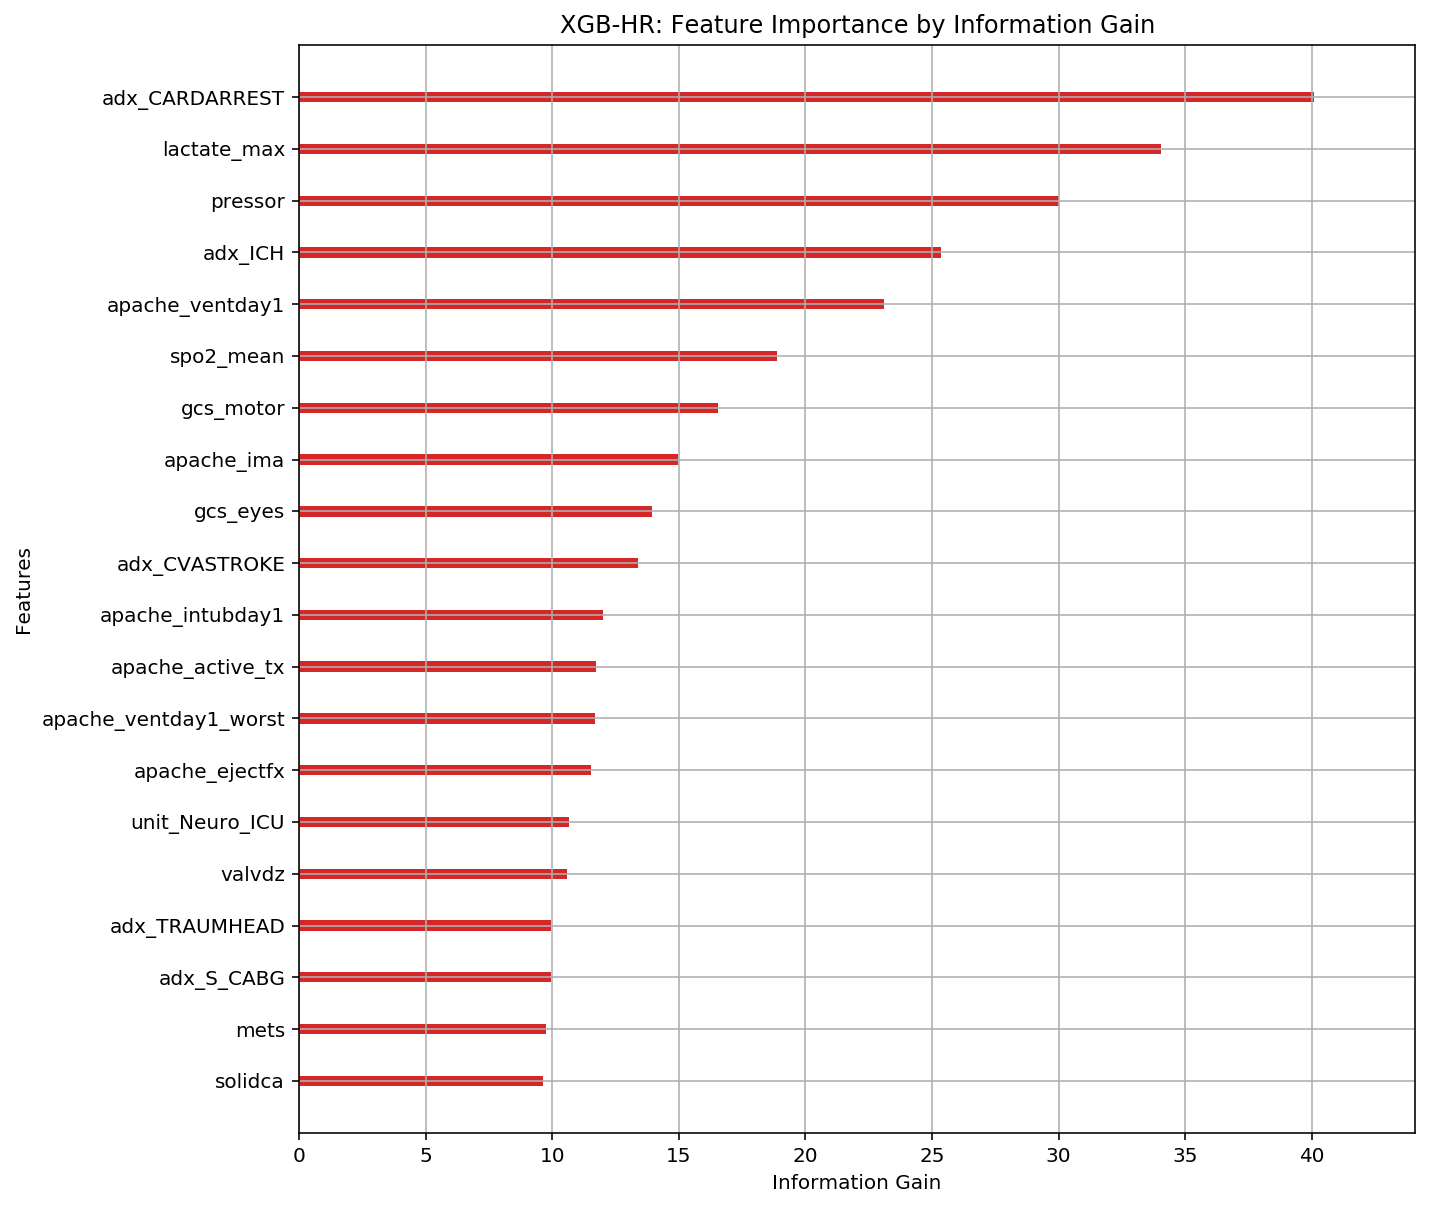

<Figure size 432x288 with 0 Axes>

In [16]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier_HR.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
                title='XGB-HR: Feature Importance by Information Gain')
plt.show()
plt.savefig('./figures/XGB_RS-feat.svg', bbox_inches='tight')

Again we note large overlaps in what features were _important_. For example, the information gain from lactate level in the HR cohort is greater than that in the full cohort. In both cases, admission for a cardiac arrest is very useful in predicting mortality, but more information is gained from the high-risk cohort.